# Troubleshooting and Solving Data Join Pitfalls

GSP412

https://www.cloudskillsboost.google/focuses/3638?parent=catalog&qlcampaign=1p-EDUCR-SG-2021-MAJULAHGCP-2-25

## Overview
BigQuery is Google's fully managed, NoOps, low cost analytics database. With BigQuery you can query terabytes and terabytes of data without having any infrastructure to manage or needing a database administrator. BigQuery uses SQL and can take advantage of the pay-as-you-go model. BigQuery allows you to focus on analyzing data to find meaningful insights.

Joining data tables can provide meaningful insight into your dataset. However when you join your data, there are common pitfalls that could corrupt your results. This lab focuses on avoiding those pitfalls. Types of joins:

- **Cross join**: combines each row of the first dataset with each row of the second dataset, where every combination is represented in the output.
- **Inner join**: requires that key values exist in both tables for the records to appear in the results table. Records appear in the merge only if there are matches in both tables for the key values.
- **Left join**: Each row in the left table appears in the results, regardless of whether there are matches in the right table.
- **Right join**: the reverse of a left join. Each row in the right table appears in the results, regardless of whether there are matches in the left table.
For more information about joins, see Join Page.

The dataset you'll use is an ecommerce dataset that has millions of Google Analytics records for the Google Merchandise Store loaded into BigQuery. You have a copy of that dataset for this lab and will explore the available fields and row for insights.

For syntax information to help you follow and update the queries, see Standard SQL Query Syntax.

In this lab, you perform these tasks:

- Use BigQuery to explore a dataset
- Troubleshoot duplicate rows in a dataset
- Create joins between data tables
- Understand each join type

# Create a new dataset to store your tables
In your BigQuery project, create a new dataset titled `ecommerce`.

Scenario: Your team provides you with a new dataset on the inventory stock levels for each of your products for sale on your ecommerce website. You want to become familiar with the products on the website and the fields you could use to potentially join on to other datasets.

The project with the new dataset is `data-to-insights`.

BigQuery public datasets are not displayed by default in the BigQuery web UI. To open the public datasets project, open https://console.cloud.google.com/bigquery?project=data-to-insights&page=ecommerce in a new browser window.

In the left pane, in the Explorer section, hover over on `data-to-insights` and click on `Click to pin` icon.

Close this browser window.

Return to and refresh the first BigQuery browser window to refresh the BigQuery web UI. The `data-to-insights` project is listed in the Explorer section.

# Examine the fields
Next, get familiar with the products and fields on the website you can use to create queries to analyze the dataset.

In the left pane in the Resources section, navigate to `data-to-insights` > `ecommerce` > `all_sessions_raw`.

On the right, under the Query editor, click the `Schema` tab to see the Fields and information about each field.

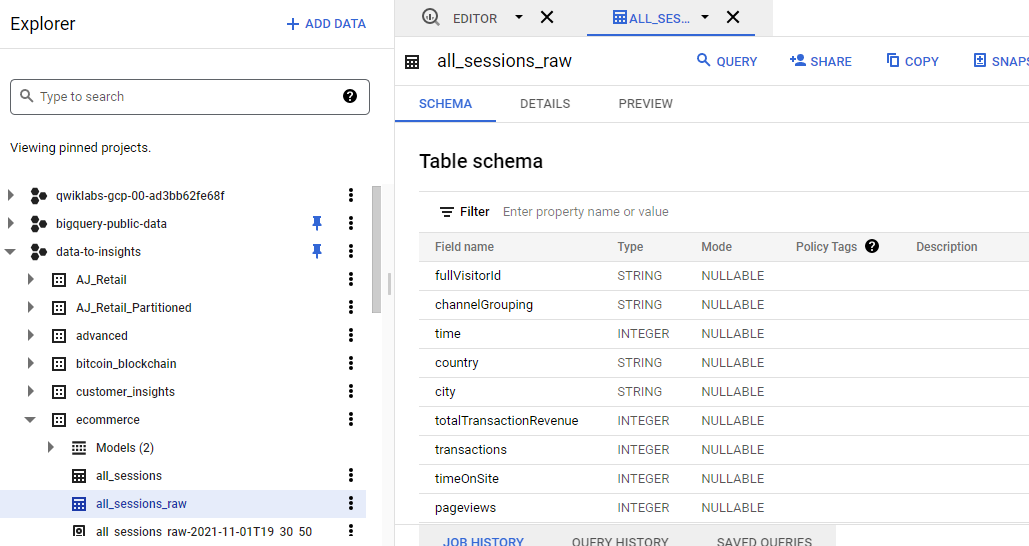

# Identify a key field in your ecommerce dataset
Examine the products and fields further. You want to become familiar with the products on the website and the fields you could use to potentially join on to other datasets.

### Examine the Records
In this section you find how many product names and product SKUs are on your website and whether either one of those fields is unique.

Find how many product names and product SKUs are on the website. Copy and Paste the below query in bigquery EDITOR.



In [ ]:
#standardSQL
# how many products are on the website?
SELECT DISTINCT
productSKU,
v2ProductName
FROM `data-to-insights.ecommerce.all_sessions_raw`

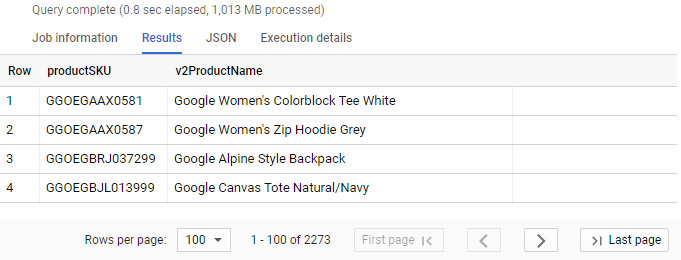

But...do the results mean that there are that many unique product SKUs? One of the first queries you will run as a data analyst is looking at the uniqueness of your data values.

Clear the previous query and run the below query to list the number of distinct SKUs are listed using `DISTINCT`.

In [ ]:
#standardSQL
# find the count of unique SKUs
SELECT
DISTINCT
productSKU
FROM `data-to-insights.ecommerce.all_sessions_raw`

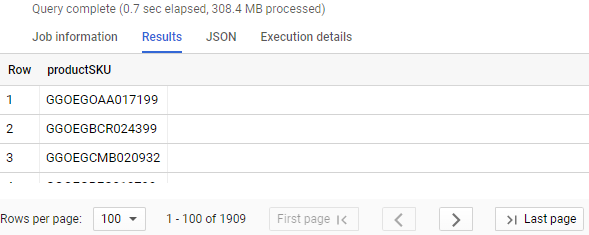

## Examine relationship between SKU & Name
Let's determine which products have more than one SKU and which SKUs have more than one Product Name.

Clear the previous query and run the below query to determine if some product names have more than one SKU. Notice we use the `STRING_AGG()` function to aggregate all the product SKUs that are associated with one product name into comma separated values.

In [ ]:
SELECT
  v2ProductName,
  COUNT(DISTINCT productSKU) AS SKU_count,
  STRING_AGG(DISTINCT productSKU LIMIT 5) AS SKU
FROM `data-to-insights.ecommerce.all_sessions_raw`
  WHERE productSKU IS NOT NULL
  GROUP BY v2ProductName
  HAVING SKU_count > 1
  ORDER BY SKU_count DESC

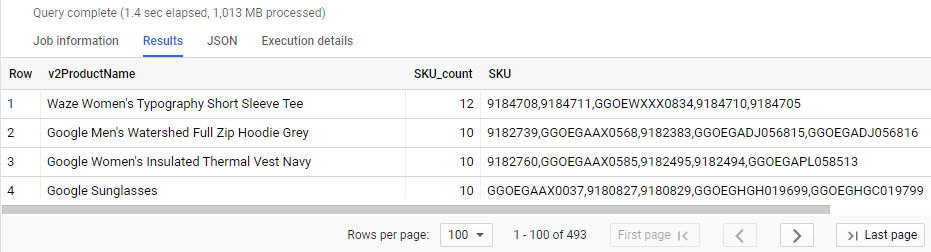

You can see on the [ecommerce website catalog](https://shop.googlemerchandisestore.com/clearance/clearance-accessories/) that each product name may have multiple options (size, color) -- which are sold as separate SKUs.

So we have seen that 1 Product can have 12 SKUs. What about 1 SKU? Should it be allowed to belong to more than 1 product?

Clear the previous query and run the below query to find out.

In [ ]:
SELECT
  productSKU,
  COUNT(DISTINCT v2ProductName) AS product_count,
  STRING_AGG(DISTINCT v2ProductName LIMIT 5) AS product_name
FROM `data-to-insights.ecommerce.all_sessions_raw`
  WHERE v2ProductName IS NOT NULL
  GROUP BY productSKU
  HAVING product_count > 1
  ORDER BY product_count DESC

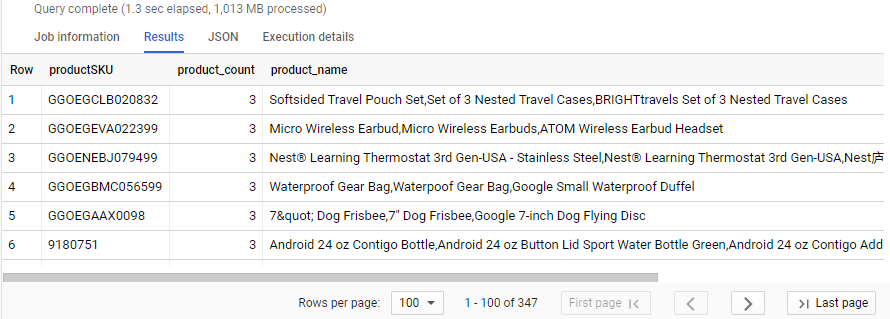

Note: Try replacing `STRING_AGG()` with `ARRAY_AGG()` instead. Pretty cool, right? BigQuery natively supports nested array values. You can learn more [here](https://cloud.google.com/bigquery/docs/reference/standard-sql/arrays).

In [ ]:
SELECT
  productSKU,
  COUNT(DISTINCT v2ProductName) AS product_count,
  ARRAY_AGG(DISTINCT v2ProductName LIMIT 5) AS product_name
FROM `data-to-insights.ecommerce.all_sessions_raw`
  WHERE v2ProductName IS NOT NULL
  GROUP BY productSKU
  HAVING product_count > 1
  ORDER BY product_count DESC

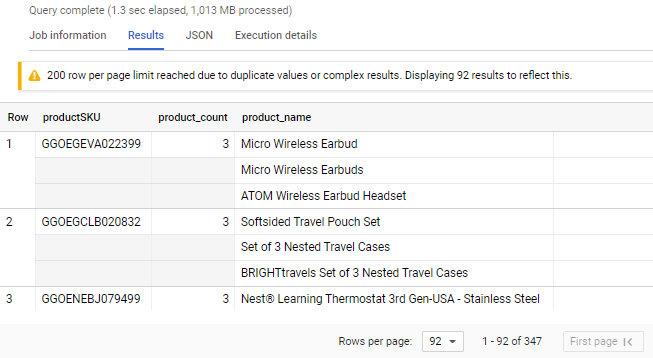

# 1. Pitfall: non-unique key
In inventory tracking, a SKU is designed to uniquely identify one and only one product. For us, it will be the basis of your JOIN condition when you lookup information from other tables. Having a non-unique key can cause serious data issues as you will see.

Write a query to identify all the product names for the SKU 'GGOEGPJC019099'.

Possible Solution:

In [ ]:
SELECT DISTINCT
  v2ProductName,
  productSKU
FROM `data-to-insights.ecommerce.all_sessions_raw`
WHERE productSKU = 'GGOEGPJC019099'

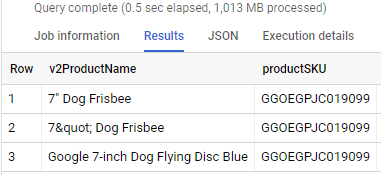

From the query results, it looks like there are three different names for the same product. In this example, there is a special character in one name and a slightly different name for another:

## Joining website data against your product inventory list
Let's see the impact of joining on a dataset with multiple products for a single SKU. First explore the product inventory dataset (the `products` table) to see if this SKU is unique there.

In [ ]:
SELECT
  SKU,
  name,
  stockLevel
FROM `data-to-insights.ecommerce.products`
WHERE SKU = 'GGOEGPJC019099'

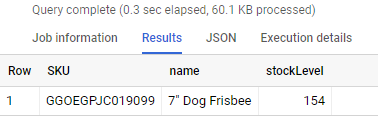

# 2. Join pitfall: Unintentional many-to-one SKU relationship
We now have two datasets: one for inventory stock level and the other for our website analytics. Let's JOIN the inventory dataset against your website product names and SKUs so you can have the inventory stock level associated with each product for sale on the website.

In [ ]:
SELECT DISTINCT
  website.v2ProductName,
  website.productSKU,
  inventory.stockLevel
FROM `data-to-insights.ecommerce.all_sessions_raw` AS website
JOIN `data-to-insights.ecommerce.products` AS inventory
  ON website.productSKU = inventory.SKU
  WHERE productSKU = 'GGOEGPJC019099'

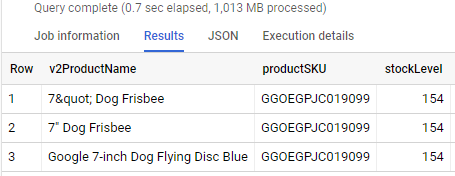

What happens when you join the website table and the product inventory table on SKU? Do you now have inventory stock levels for the product?

Yes, we have inventory levels but the `stockLevel` is showing three times (one for each record).

Next, let's expand our previous query to simply `SUM` the inventory available by product.

In [ ]:
WITH inventory_per_sku AS (
  SELECT DISTINCT
    website.v2ProductName,
    website.productSKU,
    inventory.stockLevel
  FROM `data-to-insights.ecommerce.all_sessions_raw` AS website
  JOIN `data-to-insights.ecommerce.products` AS inventory
    ON website.productSKU = inventory.SKU
    WHERE productSKU = 'GGOEGPJC019099'
)
SELECT
  productSKU,
  SUM(stockLevel) AS total_inventory
FROM inventory_per_sku
GROUP BY productSKU

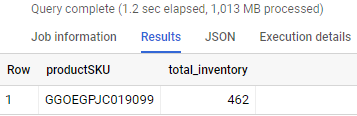

Oh no! It is 154 x 3 = 462 or triple counting the inventory! This is called an unintentional cross join (a topic we'll revisit later).

# Join pitfall solution: use distinct SKUs before joining
What are the options to solve your triple counting dilemma? First you need to only select distinct SKUs from the website before joining on other datasets.

We know that there can be more than one product name (like 7" Dog Frisbee) that can share a single SKU.

Let's gather all the possible names into an array:

In [ ]:
SELECT
  productSKU,
  ARRAY_AGG(DISTINCT v2ProductName) AS push_all_names_into_array
FROM `data-to-insights.ecommerce.all_sessions_raw`
WHERE productSKU = 'GGOEGAAX0098'
GROUP BY productSKU

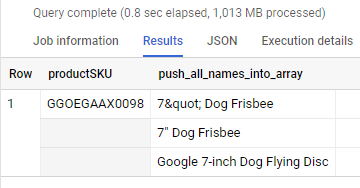

Now instead of having a row for every Product Name, we only have a row for each unique SKU.

If you wanted to deduplicate the product names, you could even `LIMIT` the array like so:

In [ ]:
SELECT
  productSKU,
  ARRAY_AGG(DISTINCT v2ProductName LIMIT 1) AS push_all_names_into_array
FROM `data-to-insights.ecommerce.all_sessions_raw`
WHERE productSKU = 'GGOEGAAX0098'
GROUP BY productSKU

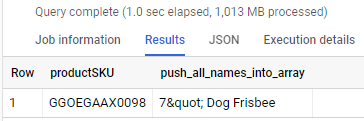

# 3. Join pitfall: Losing data records after a join
Now you're ready to join against your product inventory dataset again.

In [ ]:
#standardSQL
SELECT DISTINCT
website.productSKU
FROM `data-to-insights.ecommerce.all_sessions_raw` AS website
JOIN `data-to-insights.ecommerce.products` AS inventory
ON website.productSKU = inventory.SKU

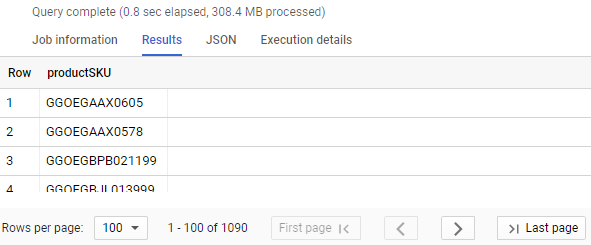

It seems we lost 819 SKUs after joining the datasets Let's investigate by adding more specificity in your fields (one SKU column from each dataset):

In [ ]:
#standardSQL
# pull ID fields from both tables
SELECT DISTINCT
website.productSKU AS website_SKU,
inventory.SKU AS inventory_SKU
FROM `data-to-insights.ecommerce.all_sessions_raw` AS website
JOIN `data-to-insights.ecommerce.products` AS inventory
ON website.productSKU = inventory.SKU
# IDs are present in both tables, how can we dig deeper?

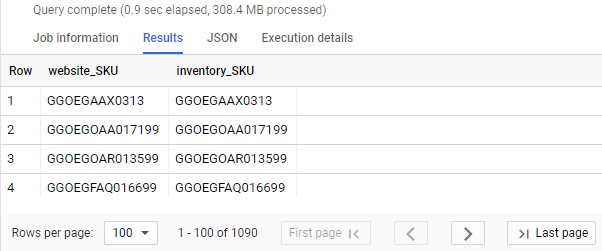

It appears the SKUs are present in both of those datasets after the join for these 1,090 records. How can we find the missing records?

**Join pitfall solution: Selecting the correct join type and filtering for NULL**

The default JOIN type is an INNER JOIN which returns records only if there is a SKU match on both the left and the right tables that are joined.

**Rewrite the previous query to use a different join type** to include all records from the website table, regardless of whether there is a match on a product inventory SKU record. Join type options: INNER JOIN, LEFT JOIN, RIGHT JOIN, FULL JOIN, CROSS JOIN

Possible Solution:

In [ ]:
#standardSQL
# the secret is in the JOIN type
# pull ID fields from both tables
SELECT DISTINCT
website.productSKU AS website_SKU,
inventory.SKU AS inventory_SKU
FROM `data-to-insights.ecommerce.all_sessions_raw` AS website
LEFT JOIN `data-to-insights.ecommerce.products` AS inventory
ON website.productSKU = inventory.SKU

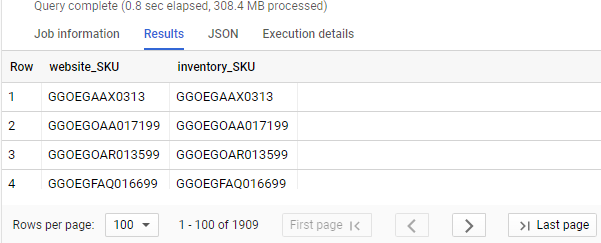

You have successfully used a LEFT JOIN to return all of the original 1,909 website SKUs in your results.

How many SKUs are missing from your product inventory set?

Write a query to filter on NULL values from the inventory table.

In [ ]:
#standardSQL
# find product SKUs in website table but not in product inventory table
SELECT DISTINCT
website.productSKU AS website_SKU,
inventory.SKU AS inventory_SKU
FROM `data-to-insights.ecommerce.all_sessions_raw` AS website
LEFT JOIN `data-to-insights.ecommerce.products` AS inventory
ON website.productSKU = inventory.SKU
WHERE inventory.SKU IS NULL

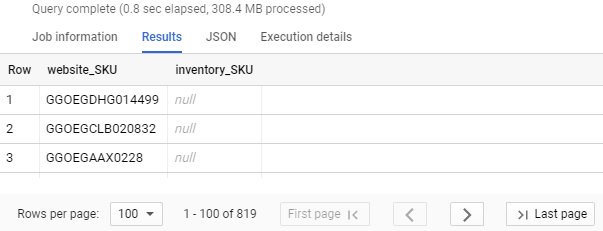

Question: How many products are missing?

Answer: 819 products are missing (SKU IS NULL) from product inventory dataset.

Run the below query to confirm using one of the specific SKUs from the website dataset.

In [ ]:
#standardSQL
# you can even pick one and confirm
SELECT * FROM `data-to-insights.ecommerce.products`
WHERE SKU = 'GGOEGATJ060517'
# query returns zero results

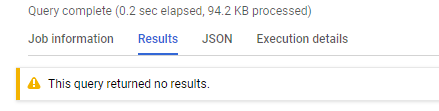

Why might the product inventory dataset be missing SKUs?

Answer: Some SKUs could be digital products that you dont store in warehouse inventory.

Now, what about the reverse situation? Are there any products are in the product inventory dataset but missing from the website?

Write a query using a different join type to investigate.

In [ ]:
#standardSQL
# reverse the join
# find records in website but not in inventory
SELECT DISTINCT
website.productSKU AS website_SKU,
inventory.SKU AS inventory_SKU
FROM `data-to-insights.ecommerce.all_sessions_raw` AS website
RIGHT JOIN `data-to-insights.ecommerce.products` AS inventory
ON website.productSKU = inventory.SKU
WHERE website.productSKU IS NULL

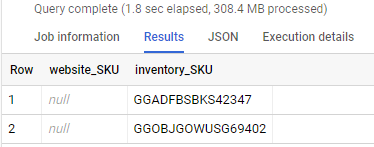

Answer: Yes. There are two product SKUs missing from the website dataset

Next, add more fields from the product inventory dataset for more details.

In [ ]:
#standardSQL
# what are these products?
# add more fields in the SELECT STATEMENT
SELECT DISTINCT
website.productSKU AS website_SKU,
inventory.*
FROM `data-to-insights.ecommerce.all_sessions_raw` AS website
RIGHT JOIN `data-to-insights.ecommerce.products` AS inventory
ON website.productSKU = inventory.SKU
WHERE website.productSKU IS NULL

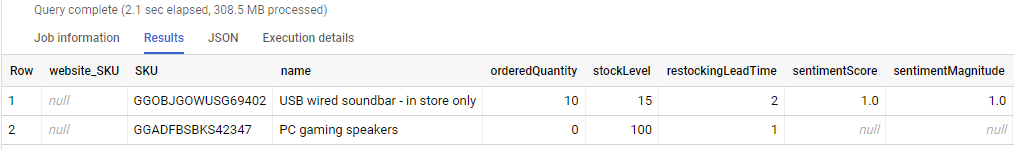

Why would these products be missing from the ecommerce website dataset?

Possible answers:

- One new product (no orders, no `sentimentScore`) and one product that is "in store only"
- Another is a new product with 0 orders

Why would the new product not show up on your website dataset?

- The website dataset is past order transactions by customers brand new products which have never been sold won't show up in web analytics until they're viewed or purchased.


You typically will not see RIGHT JOINs in production queries. You would simply just do a LEFT JOIN and switch the ordering of the tables.

What if you wanted one query that listed all products missing from either the website or inventory?

Write a query using a different join type.

Possible Solution:

In [ ]:
#standardSQL
SELECT DISTINCT
website.productSKU AS website_SKU,
inventory.SKU AS inventory_SKU
FROM `data-to-insights.ecommerce.all_sessions_raw` AS website
FULL JOIN `data-to-insights.ecommerce.products` AS inventory
ON website.productSKU = inventory.SKU
WHERE website.productSKU IS NULL OR inventory.SKU IS NULL

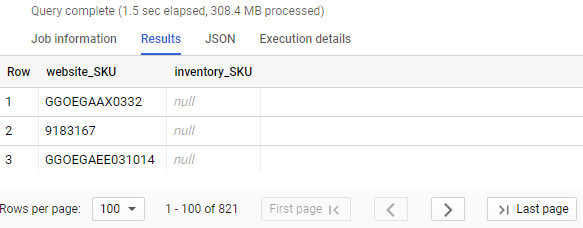

You have your 819 + 2 = 821 product SKUs

LEFT JOIN + RIGHT JOIN = FULL JOIN which returns all records from both tables regardless of matching join keys. You then filter out where you have mismatches on either side

# 4. Join pitfall: Unintentional Cross Join
Not knowing the relationship between data table keys (1:1, 1:N, N:N) can return unexpected results and also significantly reduce query performance.

The last join type is the CROSS JOIN.

Create a new table with a site-wide discount percent that you want applied across products in the `Clearance` category.

Clear the previous query and run the below query.

In [ ]:
#standardSQL
CREATE OR REPLACE TABLE ecommerce.site_wide_promotion AS
SELECT .05 AS discount;

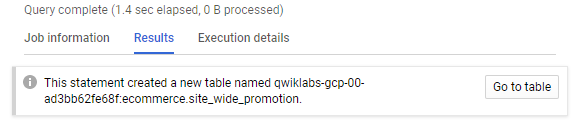

In the left pane, `site_wide_promotion` is now listed in the Resource section under your project and dataset.

Clear the previous query and run the below query to find out how many products are in clearance.

In [ ]:
SELECT DISTINCT
productSKU,
v2ProductCategory,
discount
FROM `data-to-insights.ecommerce.all_sessions_raw` AS website
CROSS JOIN ecommerce.site_wide_promotion
WHERE v2ProductCategory LIKE '%Clearance%'

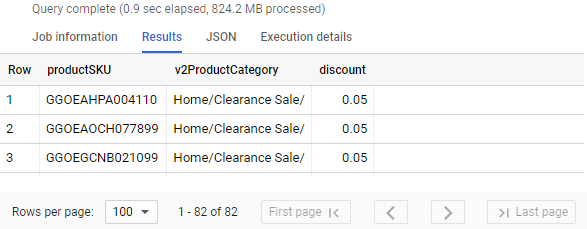

Note: For a CROSS JOIN you will notice there is no join condition (e.g. ON or USING). The field is simply multiplied against the first dataset or .05 discount across all items.

Let's see the impact of unintentionally adding more than one record in the discount table.

Clear the previous query and run the below query to insert two more records into the promotion table.

In [ ]:
INSERT INTO ecommerce.site_wide_promotion (discount)
VALUES (.04),
       (.03);

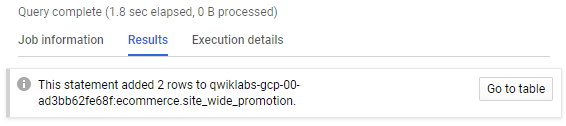

Next let's view the data values in the promotion table.

In [ ]:
SELECT discount FROM ecommerce.site_wide_promotion

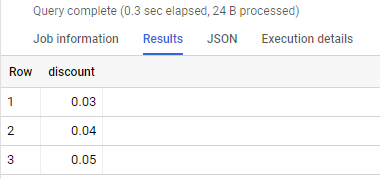

How many records were returned?

Answer: 3

What happens when you apply the discount again across all 82 clearance products?

In [ ]:
SELECT DISTINCT
productSKU,
v2ProductCategory,
discount
FROM `data-to-insights.ecommerce.all_sessions_raw` AS website
CROSS JOIN ecommerce.site_wide_promotion
WHERE v2ProductCategory LIKE '%Clearance%'

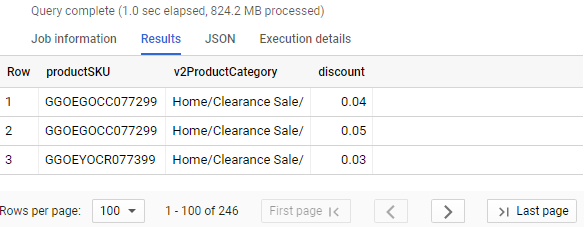

How many products are returned?

Answer: Instead of 82, you now have 246 returned which is more records than your original table started with.

Let's investigate the underlying cause by examining one product SKU.

Clear the previous query and run the below query.

In [ ]:
#standardSQL
SELECT DISTINCT
productSKU,
v2ProductCategory,
discount
FROM `data-to-insights.ecommerce.all_sessions_raw` AS website
CROSS JOIN ecommerce.site_wide_promotion
WHERE v2ProductCategory LIKE '%Clearance%'
AND productSKU = 'GGOEGOLC013299'

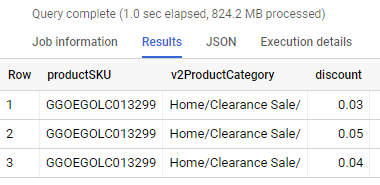

What was the impact of the CROSS JOIN?

Answer:

Since there are 3 discount codes to cross join on, you are multiplying the original dataset by 3

Note: this behavior isn't limited to cross joins, with a normal join you can unintentionally cross join when the data relationships are many-to-many this can easily result in returning millions or even billions of records unintentionally

The solution is to know your data relationships before you join and don't assume keys are unique.